In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [3]:
df=pd.read_csv('../../Database/DB_v2.csv',index_col=False)
df=df.drop(['Unnamed: 0'],axis=1)
scaler=StandardScaler()


In [4]:
y=df['DEF_PAY']
X=scaler.fit_transform(df.drop(['DEF_PAY'],axis=1))

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import joblib

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

In [30]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=10):
    skf = StratifiedKFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'accuracy'}    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    gs = GridSearchCV(model, cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='AUC')
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

In [15]:
kdc=KDEClassifier()
param_grid = {'bandwidth':np.arange(0.05,1,.1)}
gs,_,_=gridSearch(kdc,param_grid,X,y,0.2)
joblib.dump(gs, 'gs_object.pkl')

KDEClassifier(bandwidth=0.9500000000000002, kernel='gaussian')
0.8040833333333334


['gs_object.pkl']

In [45]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE 

def experimentar(X,Y,oversampling=False):
    #Validamos el modelo
    Folds = 5
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = KDEClassifier(bandwidth=0.9555, kernel='gaussian')
        if oversampling:
            print('Holi')
            sm = SMOTE(random_state=42)
            Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)
        model.fit(X=Xtrain, y=Ytrain)
        Yest = model.predict_proba(Xtest)
        Yest=np.nan_to_num(Yest)
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1),normalize=True) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

<ipython-input-6-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)


              precision    recall  f1-score   support

           0       0.82      0.96      0.89      4673
           1       0.65      0.28      0.39      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.62      0.64      6000
weighted avg       0.79      0.81      0.78      6000



<ipython-input-6-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)


,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.732243,0.017917,0.620922,0.008676


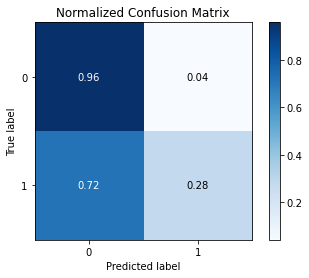

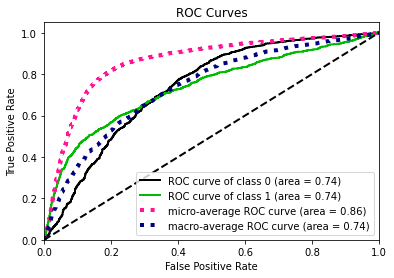

In [46]:
experimentar(X,y,False)

Holi


<ipython-input-6-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)


Holi
Holi
Holi
Holi
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4673
           1       0.48      0.53      0.50      1327

    accuracy                           0.77      6000
   macro avg       0.67      0.68      0.68      6000
weighted avg       0.78      0.77      0.77      6000



<ipython-input-6-5b9b2a44f081>:30: RuntimeWarning: invalid value encountered in true_divide
  return result / result.sum(1, keepdims=True)


,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.728692,0.016554,0.678709,0.014747


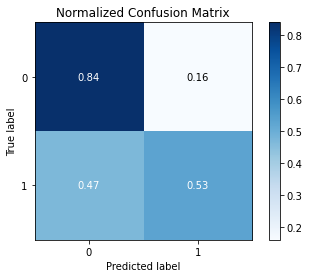

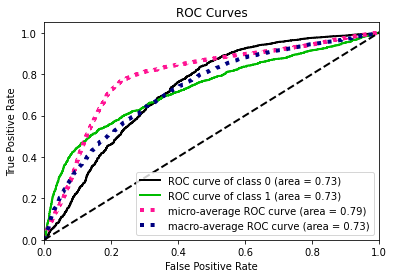

In [47]:
experimentar(X,y,True)